## Market Basket Analysis

In the first part of the code, we will be exporting the DataFrame by quering through bigquery.

We chose to perform a MBA across data of Italian transactions since we belive it makes sense to analyze country-wise and not globally-wise. In fact, Market Basket Analysis may vary according to the country featured: therefore, we think that focusing on multiple countries could have led us to misleading results as different countries have different customers, and hence different purchasing habits.

In [4]:
from google.colab import auth
auth.authenticate_user()

In [5]:
from google.cloud import bigquery
client = bigquery.Client(project='inn-intarget-lab-unimi')

In [6]:
sql_query = ('''SELECT CustomerId, date, InvoiceId, SKU, productQuantity
                FROM lab.orders
                WHERE country = "Italy"
                ''')
frame = client.query(sql_query).to_dataframe()

In [7]:
import pandas as pd
import numpy as np

In [8]:
df = frame.copy()

In [9]:
# Change format of date to datetime

df["date"] = pd.to_datetime(df["date"], format = "%Y%m%d")


In [10]:
df = df.sort_values(by = ["date", "CustomerId", "InvoiceId", "SKU"])
df = df.reset_index(drop=True)
df.head()

,CustomerId,date,InvoiceId,SKU,productQuantity
0,+/BTaw8G8hgs0ERkBCrdSA==,2021-01-01,vhNR6A2Fb98E6S5Y6BxzoQ==,+W413MnhVxs1IP9VFEVJ/w==,2
1,+/BTaw8G8hgs0ERkBCrdSA==,2021-01-01,vhNR6A2Fb98E6S5Y6BxzoQ==,AHtyMfWI1yW6fR2l9RxhIg==,2
2,+/BTaw8G8hgs0ERkBCrdSA==,2021-01-01,vhNR6A2Fb98E6S5Y6BxzoQ==,NH5/aveTPXlIByPGDJeJ2w==,2
3,+/BTaw8G8hgs0ERkBCrdSA==,2021-01-01,vhNR6A2Fb98E6S5Y6BxzoQ==,lTeuy5tIADk/MjTqnLiMgw==,2
4,+jVikdX7wC1UU4H67fNzeA==,2021-01-01,58ZjMlpNP8HS0vxe7fcvIg==,/a2BVYfh9eehujFZ+07AOw==,2


The DataFrame displays *temporally ordered transactions* of several Customers (represented as unique *CustomerId* (SKU) of an unknown company. 
Each transaction is represented by different unique InvoiceId that refers to a singular product (encrypted as *SKU* code) purchased in different quantities at a certain price. 

Although the transaction might have happened in different moments of the day, 
for analytical reasons, we will assume that different invoices with the same ID are part of the same *basket*.

In order to perform a MBA, we will only need two columns of the dataframe: "InvoiceID" & "SKU".
Let's observe the two columns on their own.
Here, we notice two characteristics:
 
 a) Both columns have been encrypted for reservedness purposes.
 
 b) We have "duplicate" InvoiceIDs that refer to the same trasaction but with different products bought.

First, in order to address a) and b), we will be assigning to each unique InvoiceID and SKU a *unique InvoiceID and SKU* integer number.

As for this, we will be creating two dataframes containing unique integers representing InvoiceID and SKU. 
Eventually, a *merge* will assign to each InvoiceId a single number, and each InvoiceId will be linked to different SKU numbers.


In [11]:
#creating unique customerid column

unique_InvoiceId = df["InvoiceId"].unique()
unique_SKU = df["SKU"].unique()

# Build arrays of integers and related dataframe for future joins

integers_InvoiceId = np.arange(0, len(unique_InvoiceId),1)
unique_InvoiceId_df = pd.DataFrame({"InvoiceId":unique_InvoiceId, "integers_invoice":integers_InvoiceId})

integers_unique_SKU = np.arange(0, len(unique_SKU),1)
unique_SKU_df = pd.DataFrame({"SKU":unique_SKU, "integers_SKU":integers_unique_SKU})

In [12]:
# Merge Dataframes and drop unneeded columns

inner_join = pd.merge(df, unique_InvoiceId_df, how="inner", on="InvoiceId")
inner_join = pd.merge(inner_join, unique_SKU_df, how="inner", on="SKU")

inner_join = inner_join.drop(["date","CustomerId",#"country",
                              "InvoiceId", "SKU", "productQuantity"], axis = 1)

inner_join

,integers_invoice,integers_SKU
0,0,0
1,27,0
2,43,0
3,61,0
4,95,0
...,...,...
1149768,227290,3095
1149769,226828,3096
1149770,227200,3096
1149771,227268,3096


In the following part, we will be creating a matrix containing **False**, in each **productQuantity** value. We created a for-loop returning **True** if productQuantity > 0. 

By doing so, we created our basket DataFrame. 
Each row represents a single transaction whereas each column represents a SKU integer product.

In [13]:
# Create 2d array with invoice and sku values

invoice_sku_list = inner_join.values.tolist()
invoice_sku_list

[[0, 0],
 [27, 0],
 [43, 0],
 [61, 0],
 [95, 0],
 [96, 0],
 [210, 0],
 [393, 0],
 [433, 0],
 [460, 0],
 [1099, 0],
 [1120, 0],
 [1125, 0],
 [1233, 0],
 [1292, 0],
 [1319, 0],
 [1341, 0],
 [2128, 0],
 [2778, 0],
 [3061, 0],
 [3112, 0],
 [3320, 0],
 [5089, 0],
 [10902, 0],
 [11619, 0],
 [11759, 0],
 [11887, 0],
 [16795, 0],
 [22907, 0],
 [31578, 0],
 [31579, 0],
 [35090, 0],
 [41387, 0],
 [51028, 0],
 [51115, 0],
 [51170, 0],
 [51308, 0],
 [69250, 0],
 [71233, 0],
 [71234, 0],
 [71281, 0],
 [71871, 0],
 [72073, 0],
 [72367, 0],
 [73245, 0],
 [77510, 0],
 [77788, 0],
 [77792, 0],
 [0, 1],
 [127, 1],
 [172, 1],
 [340, 1],
 [359, 1],
 [470, 1],
 [678, 1],
 [682, 1],
 [765, 1],
 [852, 1],
 [885, 1],
 [893, 1],
 [913, 1],
 [990, 1],
 [1043, 1],
 [1083, 1],
 [1333, 1],
 [1375, 1],
 [2468, 1],
 [3027, 1],
 [4377, 1],
 [5055, 1],
 [5765, 1],
 [5787, 1],
 [6225, 1],
 [6322, 1],
 [6478, 1],
 [6762, 1],
 [7690, 1],
 [9432, 1],
 [9504, 1],
 [10049, 1],
 [10396, 1],
 [11483, 1],
 [11518, 1],
 [13327,

In [14]:
# Build empty matrix with the size len_id x len_sku

len_sku, len_id = inner_join.integers_SKU.nunique(), inner_join.integers_invoice.nunique()
dict_counter = {any_sku:[False]*len_id   for any_sku in range(len_sku)}

# Update matrix with a true value if the there is that specific product inside that specific basket
for id, sku in invoice_sku_list:
  dict_counter[sku][id] = True

basket_df = pd.DataFrame(dict_counter)
basket_df

,0,1,2,3,4,5,6,7,8,9,...,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096
0,True,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227514,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
227515,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
227516,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
227517,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


###  Applying the Apriori Algorithm importing apriori from mlxtend library.

In [15]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

By seeking in basket_df, the Apriori Algorithm by mlxtend will help us in spotting those items that are occur in at least 0.3% of baskets.

In [16]:
basket_apriori = apriori(basket_df, min_support = 0.003, 
                             use_colnames=True).sort_values("support", ascending = False).reset_index(drop=True)
basket_apriori
                        

,support,itemsets
0,0.049877,(2471)
1,0.047381,(2419)
2,0.046071,(2408)
3,0.045201,(2400)
4,0.041153,(2448)
...,...,...
444,0.003028,(1109)
445,0.003015,(2948)
446,0.003015,(2555)
447,0.003006,(342)


Our algorithm prints 448 items that complies.

The next algorithm by the same library will represent the core of the work. It helps us to find the rules that will determine what items should be suggested (*consequents*) in relation to what items occurrs the most across transactions. Since we want to plot our results by using heatmaps and scatterplots, we want to make sure that our rules are not encoded as "frozensets".
The following cells makes sure that each rule is encoded correctly into string type. As for this, we will be applying a *lambda* function as well as the *strip* one

In [17]:
ar = association_rules(basket_apriori, metric = "lift", min_threshold=0).sort_values("support", ascending = False).reset_index(drop=True)

In [18]:
# Removing frozensets and joining tables to show actual products instead of product codes

ar.antecedents = ar.apply(lambda x: x.astype("unicode")).antecedents.str.strip("frozenset({)}").astype(np.int16)
ar.consequents = ar.apply(lambda x: x.astype("unicode")).consequents.str.strip("frozenset({)}").astype(np.int16)

# Carry out merge and re-order columns for better view

ar_sku = pd.merge(ar, unique_SKU_df, how="inner", left_on="antecedents", right_on="integers_SKU")
ar_sku_2 = pd.merge(ar_sku, unique_SKU_df, how="inner", left_on="consequents", right_on="integers_SKU")

ar_sku_2 = ar_sku_2.drop(["integers_SKU_x", "integers_SKU_y"], axis = 1).rename(columns={"SKU_x": "antecedents_SKU", "SKU_y":"consequents_SKU"})
ar_sku_2 = ar_sku_2[["antecedents_SKU", "consequents_SKU", "antecedents", "consequents", "support", "antecedent support", "consequent support", "confidence", "lift", "leverage", "conviction"]]

ar_sku_2


,antecedents_SKU,consequents_SKU,antecedents,consequents,support,antecedent support,consequent support,confidence,lift,leverage,conviction
0,KD8gVxMvnTCVNPziLxM9qw==,Twcu9ljld1EJXaOXD2/BfA==,2444,310,0.007336,0.039434,0.015379,0.186023,12.095973,0.006729,1.209643
1,KD8gVxMvnTCVNPziLxM9qw==,IW9+FcC0FkhK/0AZbKcpLg==,2444,2443,0.003481,0.039434,0.022301,0.088275,3.958249,0.002602,1.072361
2,KD8gVxMvnTCVNPziLxM9qw==,hcG//IKATBX8uo6m9a4aLA==,2444,2495,0.003134,0.039434,0.022218,0.079469,3.576817,0.002258,1.062194
3,KD8gVxMvnTCVNPziLxM9qw==,trKSjgiHifO0jaWFCOByrg==,2444,2794,0.003094,0.039434,0.005648,0.078466,13.893061,0.002872,1.079019
4,KD8gVxMvnTCVNPziLxM9qw==,4sGKI//knL2P3AGk3uI8WA==,2444,2471,0.003090,0.039434,0.049877,0.078355,1.570957,0.001123,1.030899
5,MO72CIeWPlpvL1lkhN/BHg==,4sGKI//knL2P3AGk3uI8WA==,2393,2471,0.006764,0.029492,0.049877,0.229359,4.598481,0.005293,1.232900
6,4ZD0tghyPSN7seYU8MqX9w==,4sGKI//knL2P3AGk3uI8WA==,2411,2471,0.005336,0.019532,0.049877,0.273177,5.477003,0.004362,1.307228
7,tc7L6/yaFrhT6Jx7uAgkUQ==,4sGKI//knL2P3AGk3uI8WA==,2468,2471,0.003376,0.012166,0.049877,0.277457,5.562800,0.002769,1.314970
8,dytz9mL9BE+oH5KjK/QhqA==,4sGKI//knL2P3AGk3uI8WA==,2437,2471,0.003226,0.015678,0.049877,0.205775,4.125640,0.002444,1.196290
9,Twcu9ljld1EJXaOXD2/BfA==,KD8gVxMvnTCVNPziLxM9qw==,310,2444,0.007336,0.015379,0.039434,0.476993,12.095973,0.006729,1.836623


In [19]:
ar_sku_2.sort_values("support", ascending=False)

,antecedents_SKU,consequents_SKU,antecedents,consequents,support,antecedent support,consequent support,confidence,lift,leverage,conviction
0,KD8gVxMvnTCVNPziLxM9qw==,Twcu9ljld1EJXaOXD2/BfA==,2444,310,0.007336,0.039434,0.015379,0.186023,12.095973,0.006729,1.209643
9,Twcu9ljld1EJXaOXD2/BfA==,KD8gVxMvnTCVNPziLxM9qw==,310,2444,0.007336,0.015379,0.039434,0.476993,12.095973,0.006729,1.836623
5,MO72CIeWPlpvL1lkhN/BHg==,4sGKI//knL2P3AGk3uI8WA==,2393,2471,0.006764,0.029492,0.049877,0.229359,4.598481,0.005293,1.232900
16,4sGKI//knL2P3AGk3uI8WA==,MO72CIeWPlpvL1lkhN/BHg==,2471,2393,0.006764,0.049877,0.029492,0.135619,4.598481,0.005293,1.122777
21,mzbXzBmhZAkc6clf3aQotQ==,BlSWReeOiUN9qyS4pF7M7A==,456,923,0.005516,0.016882,0.009898,0.326738,33.010242,0.005349,1.470604
23,BlSWReeOiUN9qyS4pF7M7A==,mzbXzBmhZAkc6clf3aQotQ==,923,456,0.005516,0.009898,0.016882,0.557282,33.010242,0.005349,2.220643
6,4ZD0tghyPSN7seYU8MqX9w==,4sGKI//knL2P3AGk3uI8WA==,2411,2471,0.005336,0.019532,0.049877,0.273177,5.477003,0.004362,1.307228
15,4sGKI//knL2P3AGk3uI8WA==,4ZD0tghyPSN7seYU8MqX9w==,2471,2411,0.005336,0.049877,0.019532,0.106979,5.477003,0.004362,1.097922
27,Lfjws/JhrpyRoHlYRUMxtg==,LrMBf71son/4DTdg5+tpGg==,2448,2400,0.004364,0.041153,0.045201,0.106056,2.346334,0.002504,1.068075
25,LrMBf71son/4DTdg5+tpGg==,Lfjws/JhrpyRoHlYRUMxtg==,2400,2448,0.004364,0.045201,0.041153,0.096558,2.346334,0.002504,1.061327


Above we can find the *association rule* algorithm outputting 23 rules that can be used for recommendation / suggestion purposes.

The association rule algorithm by mlxtend library helps us to find the Association Rules of our Market Basket Analysis. Since we are interested in finding occurrences between two items, we use *lift* value as _metric_. 
- A *lift* value greater than one tells us that two item occur in transaction more often than we would expect based on their individual support. Therefore, it is unlikely that the relation is explained just by random chance. Similarly, the metric *leverage* differs only in how the value is output: it will be bounded between -1 and 1. 
1 means that the consequent appears in every transaction in which there is the antecedent,  also meaning that they are highly correlated. We can interpret contrairly the leverage value -1.
- Within a rule, *confidence* assesses the probability of purchasing a consequent given his antecedent.
- *Support* tells us the occurrence of the rule in the dataset, i.e how often the two products have been purchased together: this is the reason why we sorted in descending order the support column. An higher support tells us that we must consider the rule, hence evaluating whether to suggest a consequent item given his antecedent. We can also note in the AR Table that two columns, namely "antecedent support" & "consequent support" show up: these two metrics help us to understand which item of the rule we should apply the recommendation to. 

In conclusion, since the dataset is extremely large, we can't afford to avoid these rules by choice even if the metrics do not entirely convince ourselves. Therefore, we choose to apply all of these rules to the dataset for future purchases.

### Graphical representation of our results

In [20]:
import seaborn as sns

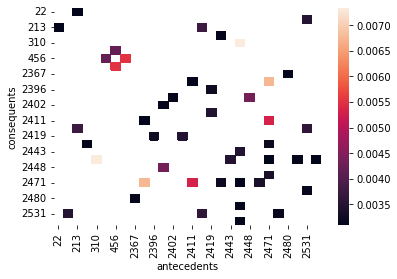

In [21]:
support_table = ar_sku_2.pivot(index = "consequents", columns = "antecedents",  values = "support") 

sns.heatmap(support_table, cbar=True, annot=False)

# Heatmap represent support as metric in a x y graph where in each axis we have our antecedents or consequents.

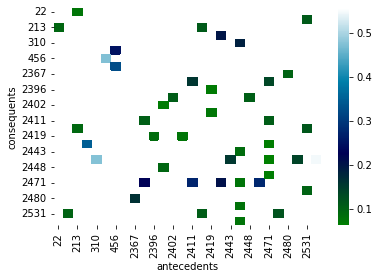

In [22]:
lift_table = ar_sku_2.pivot(index = "consequents", columns = "antecedents",  values = "confidence") 

sns.heatmap(lift_table, cbar=True, annot=False, cmap="ocean")

# Similarly to above, this heatmap features value such as "confidence".

In [23]:
colorato = np.logical_or(ar_sku_2["support"] > 0.004, ar_sku_2["confidence"] > 0.20) # preparing a set that will be used in the next cell.
ar_sku_2[colorato]

,antecedents_SKU,consequents_SKU,antecedents,consequents,support,antecedent support,consequent support,confidence,lift,leverage,conviction
0,KD8gVxMvnTCVNPziLxM9qw==,Twcu9ljld1EJXaOXD2/BfA==,2444,310,0.007336,0.039434,0.015379,0.186023,12.095973,0.006729,1.209643
5,MO72CIeWPlpvL1lkhN/BHg==,4sGKI//knL2P3AGk3uI8WA==,2393,2471,0.006764,0.029492,0.049877,0.229359,4.598481,0.005293,1.232900
6,4ZD0tghyPSN7seYU8MqX9w==,4sGKI//knL2P3AGk3uI8WA==,2411,2471,0.005336,0.019532,0.049877,0.273177,5.477003,0.004362,1.307228
7,tc7L6/yaFrhT6Jx7uAgkUQ==,4sGKI//knL2P3AGk3uI8WA==,2468,2471,0.003376,0.012166,0.049877,0.277457,5.562800,0.002769,1.314970
8,dytz9mL9BE+oH5KjK/QhqA==,4sGKI//knL2P3AGk3uI8WA==,2437,2471,0.003226,0.015678,0.049877,0.205775,4.125640,0.002444,1.196290
9,Twcu9ljld1EJXaOXD2/BfA==,KD8gVxMvnTCVNPziLxM9qw==,310,2444,0.007336,0.015379,0.039434,0.476993,12.095973,0.006729,1.836623
13,trKSjgiHifO0jaWFCOByrg==,KD8gVxMvnTCVNPziLxM9qw==,2794,2444,0.003094,0.005648,0.039434,0.547860,13.893061,0.002872,2.124487
15,4sGKI//knL2P3AGk3uI8WA==,4ZD0tghyPSN7seYU8MqX9w==,2471,2411,0.005336,0.049877,0.019532,0.106979,5.477003,0.004362,1.097922
16,4sGKI//knL2P3AGk3uI8WA==,MO72CIeWPlpvL1lkhN/BHg==,2471,2393,0.006764,0.049877,0.029492,0.135619,4.598481,0.005293,1.122777
20,k78MyN//a6O9cEBWzeg0iQ==,dytz9mL9BE+oH5KjK/QhqA==,260,2437,0.003134,0.008957,0.015678,0.349853,22.315155,0.002993,1.513999


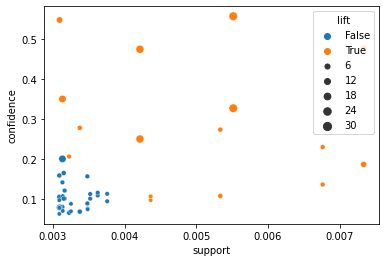

In [24]:
sns.scatterplot(x="support", y = "confidence", data=ar_sku_2, size="lift", hue=colorato)

# We chose to plot a scatterplot that would enhance the rules that our ipothetical customer should focus on the most: those are the ones marked in orange, 
# hence those that either shows an high support or an high confidence.
# It is relevant to note that these also display a great value of lift.